# Code to import files from Google Drive folders

# Necessary Library Imports
Notes and code above this are for reference

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

from mpltools import layout

## Loading File in as numpy array

Convert _.csv_ file to pandas dataframe

In [91]:
data_file = "ESP_Output.xlsx"

dataframe = pd.read_excel("../"+data_file)
sensor_data = dataframe['datapoints'].to_numpy()

Fs = 100000 # Sampling frequency - 360Hz
num_datapoints = len(sensor_data)
millis_of_data = (num_datapoints/Fs) * 1000
print(f"{millis_of_data} ms of data")

# Composition of Input signal


It can be seen from the section of sensor data below that the data shows the characteristic sensor peaks as seen in the diagram above.

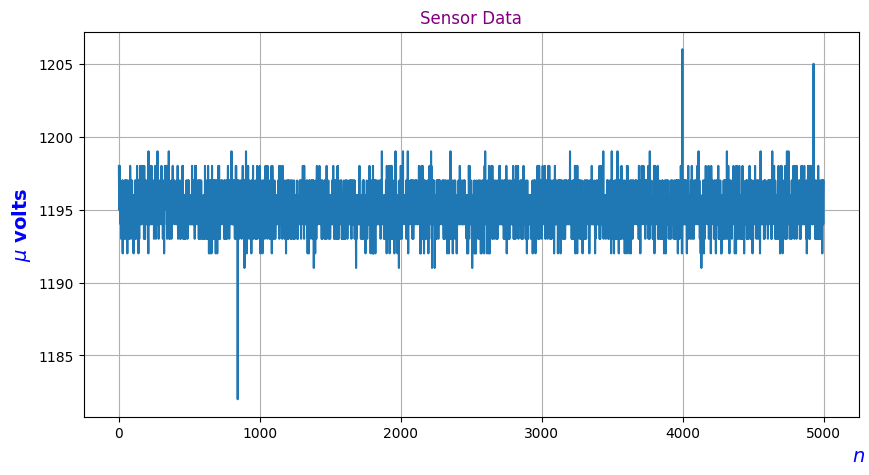

In [93]:
plt.figure(figsize = (10,5)) # 10 in by 6 in
plt.plot(sensor_data)
plt.title("Sensor Data", color ="purple")
plt.ylabel('$\mu$ volts', fontsize=14, color="blue", weight="bold")
plt.xlabel('$n$', fontsize=14, color="blue", weight="bold",  x=1.0)
plt.grid(True)

## Spectral estimation

The decision was made to use the scipy welch function in order to determine the spectral contents of the signal.

The welch function uses windowing and averaging together to help reduce the bias and variance while not compromising the resolution in spectral estimation.

Here, Welch's method was used with a segment length of 1024 and 50% overlap, utilising a hamming window to smooth the data.

In [94]:
f_sensor, sensor_welchperiodogram = signal.welch(sensor_data, Fs, 'hamming', nperseg=1024, detrend=False)

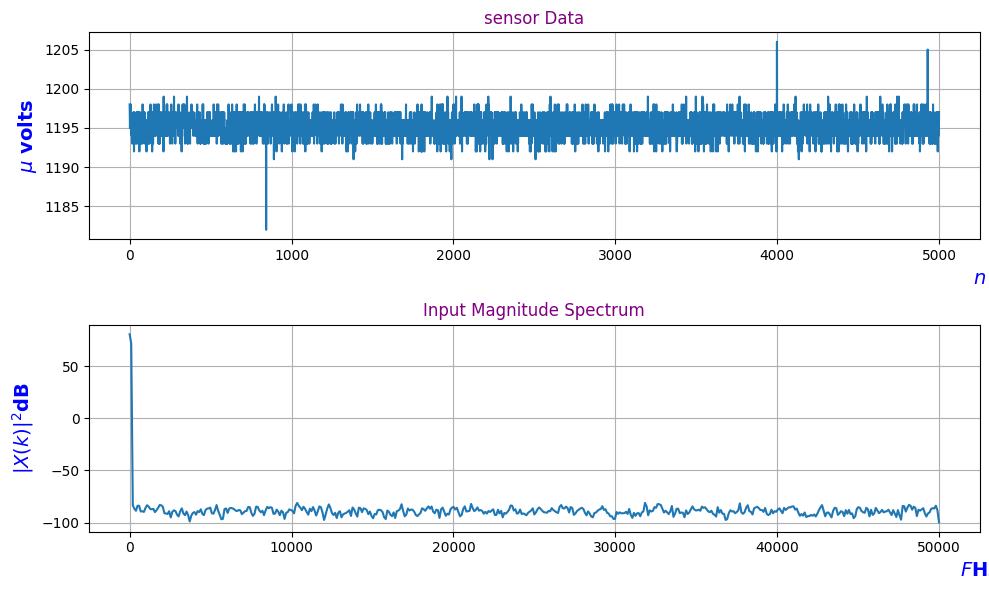

In [95]:
plt.figure(figsize = (10,6)) # 10 in by 6 in
plt.subplot(211)
plt.plot(sensor_data) # Show 5.6 seconds of data
plt.title("sensor Data", color ="purple")
plt.ylabel('$\mu$ volts', fontsize=14, color="blue", weight="bold")
plt.xlabel('$n$', fontsize=14, color="blue", weight="bold",  x=1.0)
plt.grid(True)

plt.subplot(212)
plt.plot(f_sensor, 20*np.log10(sensor_welchperiodogram))
plt.title("Input Magnitude Spectrum", color ="purple")
plt.ylabel('$|X(k)|^2$dB', fontsize=14, color="blue", weight="bold")
plt.xlabel('$F$Hz', fontsize=14, color="blue", weight="bold",  x=1.0)
# plt.xticks([0,5,15,90,120,150])
plt.tight_layout() # ensure sufficient spacing between subplots
plt.grid(True)


# Filter Design

## High Pass Filter Design

In [96]:
deltaHPF = 1000 # Transition Bandwidth in Hz
HPPassbandF = 39000  # Passband Edge Frequency in Hz
FcHP = HPPassbandF - deltaHPF/2   # Cutoff Frequency in Hz


# Hamming
M_hamming = int(np.ceil(3.3 * Fs/deltaHPF)) # Filter Length for Hamming Window

M_hamming = M_hamming + 1 if M_hamming % 2 == 0 else M_hamming # Ensure filter length is odd
print(f"M_hamming = {M_hamming}")

MidM_hamming = int((M_hamming-1)/2)
print(f"MidM_hamming = {MidM_hamming}")

ncoeffHP_hamming = signal.firwin(M_hamming, FcHP, window = 'hamming', fs = Fs, pass_zero=False)

w_hamming, HWHP_hamming = signal.freqz(ncoeffHP_hamming, fs = Fs)

sensor_HPoutput = signal.lfilter(ncoeffHP_hamming, [1.0], sensor_data)


f_HP, sensor_HPoutputwelch =  signal.welch(sensor_HPoutput, Fs, 'blackman', nperseg=1024, detrend=False)

M_hamming = 331
MidM_hamming = 165


In [60]:
print(len(ncoeffHP_hamming))

331


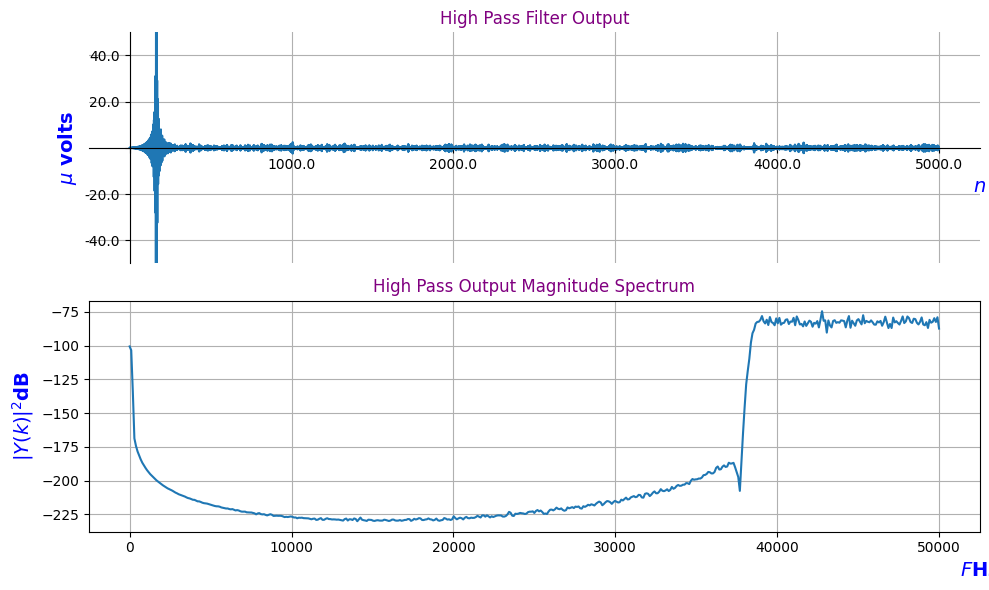

In [97]:
plt.figure(figsize = (10,6)) # 10 in by 6 in
plt.subplot(211)
plt.plot(sensor_HPoutput)
plt.title("High Pass Filter Output", color ="purple")
plt.ylabel('$\mu$ volts', fontsize=14, color="blue", weight="bold")
plt.xlabel('$n$', fontsize=14, color="blue", weight="bold",  x=1.0)
plt.ylim(-50, 50)
plt.grid(True)
layout.cross_spines(zero_cross=True)

plt.subplot(212)
plt.plot(f_HP, 20*np.log10(sensor_HPoutputwelch))
plt.title("High Pass Output Magnitude Spectrum", color ="purple")
plt.ylabel('$|Y(k)|^2$dB', fontsize=14, color="blue", weight="bold")
plt.xlabel('$F$Hz', fontsize=14, color="blue", weight="bold",  x=1.0)
# plt.xticks([5,15,90,120,150])
plt.grid(True)
plt.tight_layout() # ensure sufficient spacing between subplots

# Lowpass Filter Design

The process for Low Pass filter design is much the same as the High Pass filter design, so once again it was decided to use the blackman filter to maximise stopband attenuation


In [98]:
deltaLPF = 1000 # Transition Bandwidth in Hz
LPPassbandF = 41000  # Passband Edge Frequency in Hz
FcLP = LPPassbandF + deltaLPF/2   # Cutoff Frequency in Hz
MLP = int(np.ceil(5.5 * Fs/deltaLPF)) # Calculate filter length M
MLP = MLP + 1 if MLP % 2 == 0 else MLP # Ensure that filter length is odd
print(f"Low Pass M = {MLP}")

MidMLP = int((MLP-1)/2) #Filter Midpoint
print(f"Mid MLP = {MidMLP}")
# Calculate FIR filter coefficients
ncoeffLP = signal.firwin(MLP, FcLP, window = 'blackman', fs = Fs, pass_zero=True)
# Calculate frequency response of designed filter
w, HWLP = signal.freqz(ncoeffLP, fs = Fs)


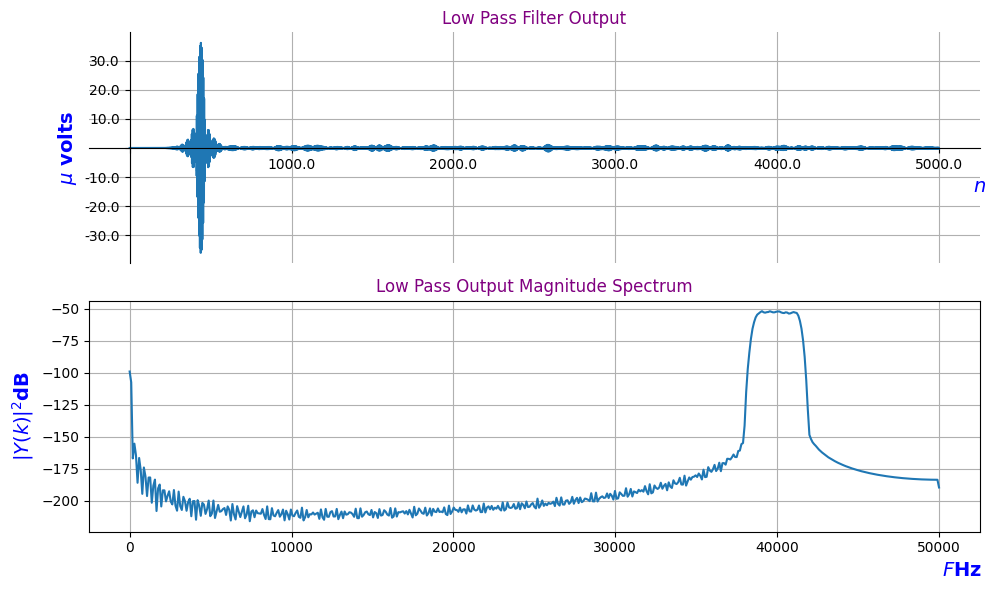

In [101]:
# Apply Low pass filter to already high pass filtered signal
sensor_LPoutput = signal.lfilter(ncoeffLP, [1.0], sensor_HPoutput)
# Calculate spectral estimation using welch method
f, sensor_LPoutputwelch =  signal.welch(sensor_LPoutput, Fs, 'hamming', nperseg=1024, detrend=False)

# Plot output signal and frequency content of filtered signal
plt.figure(figsize = (10,6)) # 10 in by 6 in
plt.subplot(211)
plt.plot(sensor_LPoutput)
plt.title("Low Pass Filter Output", color ="purple")
plt.ylabel('$\mu$ volts', fontsize=14, color="blue", weight="bold")
plt.xlabel('$n$', fontsize=14, color="blue", weight="bold",  x=1.0)
layout.cross_spines(zero_cross=True)
plt.grid(True)

plt.subplot(212)
plt.plot(f, 20*np.log10(sensor_LPoutputwelch))
plt.title("Low Pass Output Magnitude Spectrum", color ="purple")
plt.ylabel('$|Y(k)|^2$dB', fontsize=14, color="blue", weight="bold")
plt.xlabel('$F$Hz', fontsize=14, color="blue", weight="bold",  x=0.98)
# plt.xticks([5,15])
# plt.axis([0, 125,-120,50])
plt.grid(True)
plt.tight_layout() # ensure sufficient spacing between subplots


# Alternative approach
An alternative approach which combats this restriction is the utilisation of an Infinite Impluse Response (IIR) Filter instead of the as seen so far Finite Impulse Response (FIR) Filters.

The Scipy function _cheby1_ was used to create a chebychev IIR High Passfilter with a cutoff of 0.5Hz

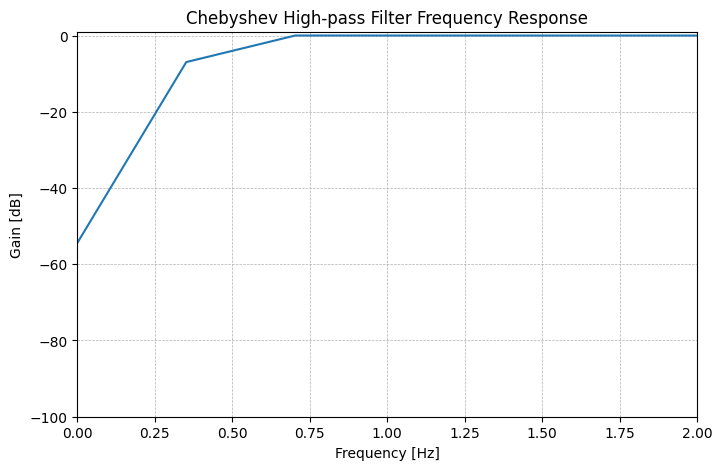

In [ ]:
delta_IIR_HPF = 2 #### Transition Bandwidth in Hz
FcLP = LPPassbandF + deltaLPF/2   ##### Cutoff Frequency in Hz ()

# High-pass filter design parameters
delta_IIR_HPF = 0.1
f_IIR_HP = 0.5 # in Hz
f_c = f_IIR_HP - delta_IIR_HPF/2
order = 6  # Chebyshev filter order

# Design the high-pass Chebyshev filter
b, a = signal.cheby1(N=order,rp = 0.01, Wn=f_c, btype='highpass', analog=False, output='ba', fs=Fs)

# Frequency response of the filter
w, h = signal.freqz(b, a, fs=Fs)

plt.figure(figsize = (8,5)) # 10 in by 5 in
plt.plot(w, 20*np.log10(abs(h)))
plt.title('Chebyshev High-pass Filter Frequency Response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain [dB]')
plt.grid(which='both', axis='both', linestyle='--', linewidth=0.5)
plt.axis([0,2,-100,1])

plt.show()


The filter's frequency response above shows the desired output with frequencies below 0.5 Hz being strongly attenuated



## Applying IIR Filter

It can be seen in the plots below that the sensor data has been filtered to attenuate frequencies below 0.5Hz while maintaining zero delay in the output signal. This is far more useful to applications that require real time filtering.

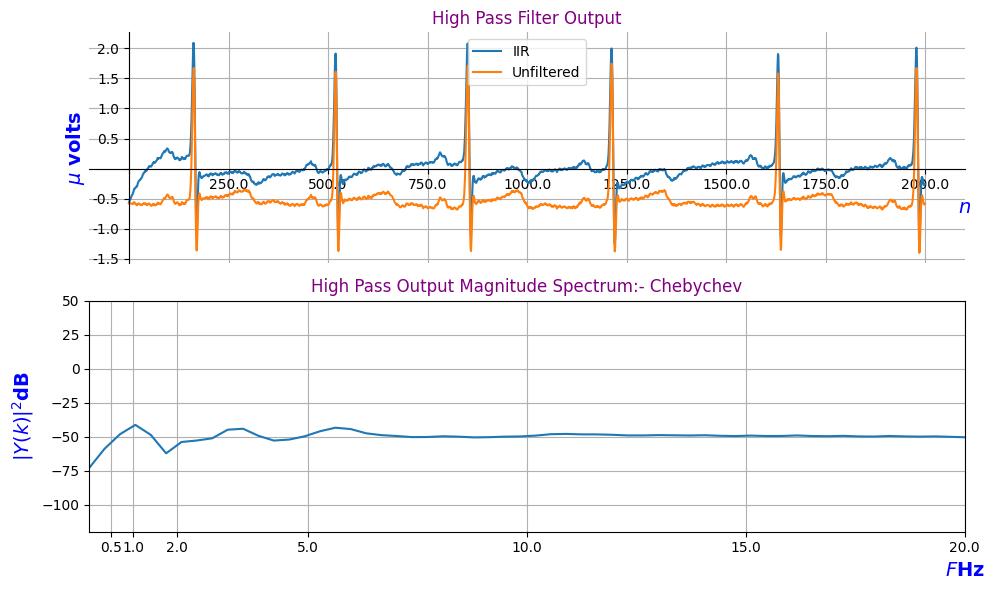

In [ ]:
# Apply IIR filter to input sensor Data
sensor_IIR_HPoutput = signal.lfilter(b, a, sensor_data)

# Perform welchs method to get spectral estimation of filtered signal
f_IIR, sensor_IIR_HPoutputwelch =  signal.welch(sensor_IIR_HPoutput, Fs, 'blackman', nperseg=1024, detrend=False)

plt.figure(figsize = (10,6)) # 10 in by 6 in
plt.subplot(211)
plt.plot(sensor_IIR_HPoutput[0:2000])
plt.plot(sensor_data[0:2000])
plt.title("High Pass Filter Output", color ="purple")
plt.ylabel('$\mu$ volts', fontsize=14, color="blue", weight="bold")
plt.xlabel('$n$', fontsize=14, color="blue", weight="bold",  x=1.0)
plt.legend(["IIR", "Unfiltered"])
layout.cross_spines(zero_cross=True)


plt.subplot(212)
plt.plot(f_IIR, 20*np.log10(sensor_IIR_HPoutputwelch))
plt.title("High Pass Output Magnitude Spectrum:- Chebychev", color ="purple")
plt.ylabel('$|Y(k)|^2$dB', fontsize=14, color="blue", weight="bold")
plt.xlabel('$F$Hz', fontsize=14, color="blue", weight="bold",  x=1.0)
plt.xticks([0.5,1,2,5,10,15,20])
plt.axis([0, 20,-120,50])
plt.grid(True)
plt.tight_layout()


# Conclusion

In conclusion, this assignment aimed to analyze and process an sensor signal obtained from the MIT-BIH Arrhythmia Database with a sampling frequency of 360 Hz. The implementation involved the design and evaluation of cascaded high-pass and low-pass FIR filters, as well as an exploration of an alternative IIR filter for lower frequency high pass filtering.

The spectrum analysis of the sensor signal showed the presence of noise components, motivating the need for effective filtering techniques. The application of the Pan Tomkins Algorithm necessitated a bandpass filter with a passband of 5 to 15 Hz to enhance the detection of R-R intervals while mitigating muscle noise, mains interference, baseline wander, and T-wave interference.

The FIR filter design employed the window method with a blackman window. It was successfully implemented and the desired bandpass filtering was achieved. Time domain simulations and frequency response analyses demonstrated the effectiveness of the FIR filter in achieving the specified passband.

Furthermore, a variation in the passband to 0.5 to 15 Hz was investigated to assess the real-time application of the FIR filter. It was shown that in real time applications FIR filters fall down due to the group delay introduced by the filter length. An alternative approach to bandpass filtering was explored, simulated, and its frequency response and output spectrum analyzed. This investigation provided valuable insights into the adaptability and performance of the FIR filter under different passband configurations.

In summary, the assignment successfully achieved its objectives by implementing and analyzing FIR and IIR filters for sensor signal processing.